In [22]:
#%run -i start_spark.py --master local[*] --driver-memory 10g
%run -i start_spark.py --master local[*] --driver-memory 1g
#%run -i start_spark.py --master spark://192.168.0.100:7077 --driver-memory 10g

Creating SparkContext...
SparkContext created.
Master URL: local[*]


**Do not forget to close the session with spark.stop()**

<Figure size 432x288 with 0 Axes>

# Fraud detection using machine learning

In the following two supervised machine learning (ML) algorithms will be tested to select a model for the fraud detection. As the data is higly inbalanced, more algorithms will be used to maximize the performances. Before deep diving in the definition of an ML model, the correlations among variables will be calculated over the whole dataset.

In [ ]:
%matplotlib inline

from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel, LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, VectorIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator

from pyspark.mllib.evaluation import MulticlassMetrics

import coursera_common as cc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [ ]:
payments_enc = cc.readParquet(spark, cc.PAYMENTS_ENC_PQT_FILENAME)

payments_enc.show(5)

In [ ]:
corr_features_cols, features_cols, dl_features_cols = cc.read_feature_cols(cc.FEATURES_CONFIG_FILENAME)

## Calculate the correlation matrix over the whole dataset

In [7]:
print('Calculate pearson correlation...')
sp_corr_tot = Correlation.corr(payments_enc.select('corrFeatures'), 'corrFeatures', 'pearson').head()
print('Complete!')

Calculate pearson correlation...
Complete!


In [9]:
correlation = pd.DataFrame(sp_corr_tot[0].toArray().tolist(), columns=corr_features_cols)

correlation.index = correlation.columns
correlation.fillna(0, inplace=True)

correlation.style.background_gradient(cmap='coolwarm')

,amount,oldbalanceOrg,oldbalanceDest,vOrig,vDest,isFraud,typeEnc
amount,1,-0.00276247,0.294137,-0.000291943,-0.197444,0.0766884,0.198987
oldbalanceOrg,-0.00276247,1,0.0662425,-0.000770596,-0.189486,0.0101544,0.260418
oldbalanceDest,0.294137,0.0662425,1,-0.000236494,-0.231455,-0.00588528,0.0662552
vOrig,-0.000291943,-0.000770596,-0.000236494,1,0.000234313,0.000469957,-0.000233488
vDest,-0.197444,-0.189486,-0.231455,0.000234313,1,-0.0256971,-0.0403023
isFraud,0.0766884,0.0101544,-0.00588528,0.000469957,-0.0256971,1,0.0161714
typeEnc,0.198987,0.260418,0.0662552,-0.000233488,-0.0403023,0.0161714,1


## Generate train and test data frames

In [ ]:
# split train and test df
train_df, test_df = payments_enc.select(['featuresIndexed', 'isFraud']).randomSplit([0.7, 0.3], seed = cc.RANDOM_SEED)
print('Training dataset count: {}'.format(train_df.count()))
print('Test Dataset Count: {}'.format(test_df.count()))

## Logistic regression

Logistic regression does not perform well with highly unbalanced data. Indeed in the test below the model is not able to identify any fraud. 

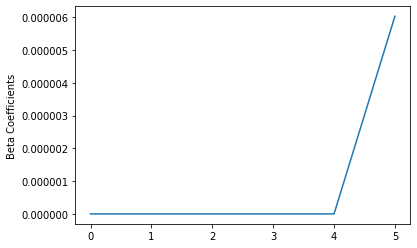

In [30]:
lr = LogisticRegression(featuresCol = 'featuresIndexed', labelCol = 'isFraud', maxIter=10)
lr_model = lr.fit(train_df)

beta = np.sort(lr_model.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

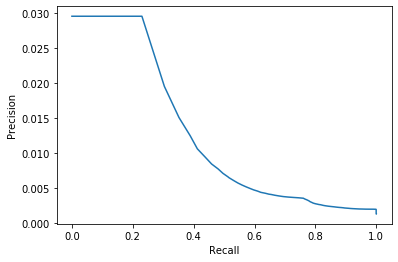

In [31]:
trainingSummary = lr_model.summary

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [33]:
# Make predictions.
predictions = lr_model.transform(test_df)

# Select example rows to display.
predictions.select("prediction", "isFraud", "featuresIndexed").show(5)

+----------+-------+--------------------+
|prediction|isFraud|     featuresIndexed|
+----------+-------+--------------------+
|       0.0|      0|[0.23,123860.0,0....|
|       0.0|      0|[0.47,19901.0,0.0...|
|       0.0|      0|[0.48,27990.0,0.0...|
|       0.0|      0|[0.55,0.0,3609.27...|
|       0.0|      0|[1.02,196944.92,0...|
+----------+-------+--------------------+
only showing top 5 rows



In [41]:

metrics = MulticlassMetrics( predictions.select('prediction', predictions.isFraud.cast('double')).rdd )
print('Precision of True : {}'.format(metrics.precision(1)) )
print('Precision of False: {}'.format(metrics.precision(0)) )
print('Recall of True    : {}'.format(metrics.recall(1)) )
print('Recall of False   : {}'.format(metrics.recall(0)) )
print('F-1 Score         : {}'.format(metrics.fMeasure()) )
print('Confusion Matrix\n{}'.format(metrics.confusionMatrix().toArray()) )

Precision of True : 0.0
Precision of False: 0.9986994763322508
Recall of True    : 0.0
Recall of False   : 1.0
F-1 Score         : 0.9986994763322508
Confusion Matrix
[[1905980.       0.]
 [   2482.       0.]]


Although the model is very accurate it is not able to predict any fraud. That is called the accuracy paradox. Linear Regression should be therefore excluded from the list of the possible algorithms for the present exercise. 

Confusion matrix, without normalization
[[1905980.       0.]
 [   2482.       0.]]


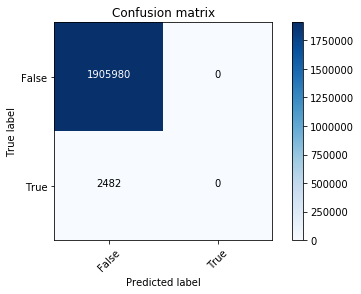

In [42]:
cc.plot_confusion_matrix(metrics.confusionMatrix().toArray(), classes=['False','True'], normalize=False)

## Random Forests

Random forests is a supervised classification algorithm consisting of many decisions trees. It performs very well with anomaly detection. It has an high number of hyperparameters that can be tuned via a grid search. Considering the limited number of features available, the best model identified tuning the hyperparameters performed well identifying 1463 frauds over 2482 (59%) total with only 391 false positives (approximately 1 false positive every 5). 

In [61]:
# Train a RandomForest model. The hyperparameters below are already the ones of the tuned model
rf = RandomForestClassifier(
        labelCol="isFraud",
        featuresCol="featuresIndexed",
        seed= cc.RANDOM_SEED_RANDOM_FOREST,
        numTrees=50,
        maxDepth=25)

In [62]:
print('Fitting the classifier...')
# Train model.  This also runs the indexers.
rf_model = rf.fit(train_df)

# Make predictions.
print('Making predictions on test data frame...')
predictions = rf_model.transform(test_df)

# Select example rows to display.
predictions.select('prediction', 'isFraud', 'featuresIndexed').show(5)

metrics = MulticlassMetrics( predictions.select('prediction', predictions.isFraud.cast('double')).rdd )

print('Precision of True : {}'.format(metrics.precision(1)) )
print('Precision of False: {}'.format(metrics.precision(0)) )
print('Recall of True    : {}'.format(metrics.recall(1)) )
print('Recall of False   : {}'.format(metrics.recall(0)) )
print('F-1 Score         : {}'.format(metrics.fMeasure()) )
print('Confusion Matrix\n{}'.format(metrics.confusionMatrix().toArray()) )

Fitting the classifier...
Making predictions on test data frame...
+----------+-------+--------------------+
|prediction|isFraud|     featuresIndexed|
+----------+-------+--------------------+
|       0.0|      0|[0.23,123860.0,0....|
|       0.0|      0|[0.47,19901.0,0.0...|
|       0.0|      0|[0.48,27990.0,0.0...|
|       0.0|      0|[0.55,0.0,3609.27...|
|       0.0|      0|[1.02,196944.92,0...|
+----------+-------+--------------------+
only showing top 5 rows

Precision of True : 0.7891046386192018
Precision of False: 0.9994655429957285
Recall of True    : 0.5894439967767929
Recall of False   : 0.9997948561894668
F-1 Score         : 0.9992611851847194
Confusion Matrix
[[1.905589e+06 3.910000e+02]
 [1.019000e+03 1.463000e+03]]


Confusion matrix, without normalization
[[1.905589e+06 3.910000e+02]
 [1.019000e+03 1.463000e+03]]


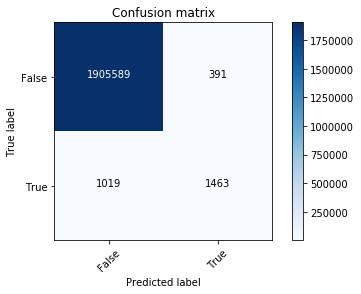

In [63]:
cc.plot_confusion_matrix(metrics.confusionMatrix().toArray(), classes=['False','True'], normalize=False)

The tuning of the model is executed with a grid search that checks different combinations of numTrees, maxDepth, inpurity and minInfoGain. It results in 54 different configurations.

Fitting the cross validator...
Best Model: RandomForestClassificationModel (uid=RandomForestClassifier_b5b3a69379d4) with 50 trees
Saving the model...
Calculating predictions...
Precision of True : 0.7891046386192018
Precision of False: 0.9994655429957285
Recall of True    : 0.5894439967767929
Recall of False   : 0.9997948561894668
F-1 Score         : 0.9992611851847194
Confusion Matrix
[[1.905589e+06 3.910000e+02]
 [1.019000e+03 1.463000e+03]]
Confusion matrix, without normalization
[[1.905589e+06 3.910000e+02]
 [1.019000e+03 1.463000e+03]]


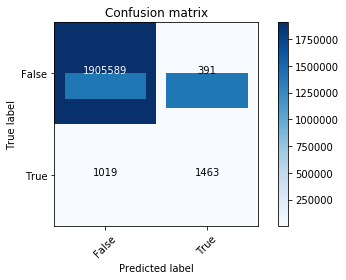

In [64]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .addGrid(rf.impurity, ['gini','entropy']) \
    .addGrid(rf.minInfoGain, [0.0, 0.05, 0.1]) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol='isFraud'),
                          numFolds=3)

print('Fitting the cross validator...')
cvModel = crossval.fit(train_df)

print('Best Model: {}'.format(cvModel.bestModel))
bestModel = cvModel.bestModel

print('Saving the model...')
cvModel.bestModel.save(cc.MODEL_RF_TUNED_BEST)

print('Calculating predictions...')
predictions = cvModel.transform(test_df)

metrics = MulticlassMetrics( predictions.select('prediction', predictions.isFraud.cast('double')).rdd )

print('Precision of True : {}'.format(metrics.precision(1)) )
print('Precision of False: {}'.format(metrics.precision(0)) )
print('Recall of True    : {}'.format(metrics.recall(1)) )
print('Recall of False   : {}'.format(metrics.recall(0)) )
print('F-1 Score         : {}'.format(metrics.fMeasure()) )
print('Confusion Matrix\n{}'.format(metrics.confusionMatrix().toArray()) )

cc.plot_confusion_matrix(metrics.confusionMatrix().toArray(), classes=['False','True'], normalize=False)



In [27]:
bestModel = RandomForestClassificationModel.load(cc.MODEL_RF_TUNED_BEST)

print('numFeatures: {}'.format(bestModel.numFeatures))
print('numClasses: {}'.format(bestModel.numClasses))
print('numTrees: {}'.format(bestModel.getNumTrees))

print('\nparams explained:\n\n{}'.format(bestModel.explainParams()))

numFeatures: 6
numClasses: 2
numTrees: 50

params explained:

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n]. (default: auto)
featuresCol: features column name (current: featuresIndexed)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name (current: isFraud)
maxBins: Max number of bins for discretizing c

Reading data/payments_enc.v6.parquet.json


Text(0.5, 1.0, 'Feature Importances')

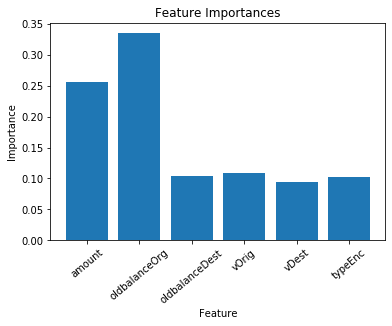

In [67]:
importances = cvModel.bestModel.featureImportances

x_values = list(range(len(importances)))

# Retrieve the features_cols variable in case not loaded
try:
    features_cols = cc.read_feature_cols(cc.FEATURES_CONFIG_FILENAME, cc.FEATURES_CONFIG_STANDARD)
except NameError:
    features_cols = [x for x in payments_enc.columns if 'features' not in x and x != 'type']

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, features_cols, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

The old balance of the origin and the amount are the features with the highest predictive power

## Isolation Forest

Isolation forests is an unsupervised classification algorithm consisting of many decisions trees. It performs very well with anomaly detection. It has an high number of hyperparameters that can be tuned via a grid search. Considering the limited number of features available, the best model identified tuning the hyperparameters had a discrete rate of true positive identified (482) frauds over 2482. Nevertheless there is a ratio of ~10 false negatives every true positive. 

As MLLib does not support isolation forest, scikit-learn has been used.

In [ ]:
# @hidden_cell
# Use skit-learn https://towardsdatascience.com/isolation-forest-and-spark-b88ade6c63ff

In [7]:
import numpy as np

from sklearn import model_selection

from sklearn.datasets import make_classification
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, make_scorer, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import coursera_common as cc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

As scikit-learn works with numpy array, the parquet vector is extracted and cached in numpy binary format for fast reproducibility of the tests.

In [8]:
REBUILD_CACHE = False

scaler = StandardScaler()

####### TRAIN
if not REBUILD_CACHE and os.path.exists( cc.IFOREST_X_TRAIN ):
    print('Loading ' + cc.IFOREST_X_TRAIN)
    x_train = np.load( cc.IFOREST_X_TRAIN )
else:
    print('Extracting x_train features as array...')
    x_train = np.array(train_df.select('featuresIndexed').collect())
    x_train = np.apply_along_axis(lambda x : x[0], 1, x_train)
    x_train = scaler.fit_transform(x_train)

    print('Saving ' + cc.IFOREST_X_TRAIN)
    np.save(cc.IFOREST_X_TRAIN, x_train)
    print('Complete!')

if not REBUILD_CACHE and os.path.exists( cc.IFOREST_Y_TRAIN ):
    print('Loading ' + cc.IFOREST_Y_TRAIN)
    y_train = np.load( cc.IFOREST_Y_TRAIN )
else:
    print('Extracting y_train features as array...')
    y_train = np.array(train_df.select('isFraud').collect())
    y_train = np.apply_along_axis(lambda x : x[0], 1, y_train)

    print('Saving ' + cc.IFOREST_Y_TRAIN)
    np.save(cc.IFOREST_Y_TRAIN, y_train)
    print('Complete!')

####### TEST
if not REBUILD_CACHE and os.path.exists( cc.IFOREST_X_TEST ):
    print('Loading ' + cc.IFOREST_X_TEST)
    x_test = np.load( cc.IFOREST_X_TEST )
else:
    print('Extracting Test features as array...')
    x_test = np.array(test_df.select('featuresIndexed').collect())
    x_test = np.apply_along_axis(lambda x : x[0], 1, x_test)
    x_test = scaler.fit_transform(x_test)

    print('Saving ' + cc.IFOREST_X_TEST)
    np.save(cc.IFOREST_X_TEST, x_test)
    print('Complete!')

if not REBUILD_CACHE and os.path.exists( cc.IFOREST_Y_TEST ):
    print('Loading ' + cc.IFOREST_Y_TEST)
    y_test = np.load( cc.IFOREST_Y_TEST )
else:
    y_test = np.array(test_df.select('isFraud').collect())
    y_test = np.apply_along_axis(lambda x : x[0], 1, y_test)
    print('Complete!')

    print('Saving ' + cc.IFOREST_Y_TEST)
    np.save(cc.IFOREST_Y_TEST, y_test)
    print('Complete!')

print('Complete!')

Loading data/iforest.x_train.v2.npy
Loading data/iforest.y_train.v2.npy
Loading data/iforest.x_test.v2.npy
Loading data/iforest.y_test.v2.npy
Complete!


In [9]:
ifc = IsolationForest(bootstrap=True, contamination=0.0015, max_samples= 0.1, n_estimators= 50, random_state=cc.RANDOM_SEED, n_jobs=-1, behaviour='new')

In [10]:
print('Fitting the model')
iForest = ifc.fit(x_train)
print('Complete!')

print('Computing prediction...')
y_predicted = iForest.predict(x_test)
print('Complete!')

Fitting the model
Complete!
Computing prediction...
Complete!


Confusion matrix, without normalization
[[1900116    5864]
 [   2000     482]]


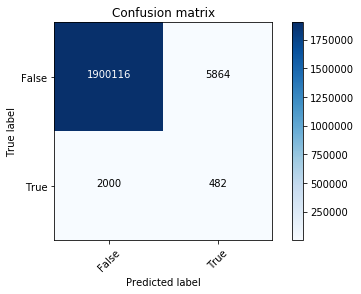

In [11]:
def translate_prediction(prediction):
    if prediction == 1:
        return 0
    elif prediction == -1:
        return 1
    else:
        return np.NaN

y_predicted_10 = np.array(list(map(translate_prediction, y_predicted)))
iforest_cm = confusion_matrix(y_test, y_predicted_10)

cc.plot_confusion_matrix(iforest_cm, classes=['False','True'], normalize=False)

In [21]:
cc.print_scores(iforest_cm)

Precision of True : 0.07595335644500473
Precision of False: 0.998948539416103
Recall of True    : 0.19419822723609992
Recall of False   : 0.9969233675064796
F-1 Score         : 0.10919800634345264


In [16]:
param_grid = {'n_jobs': [1],
              'n_estimators': np.linspace(25, 100, 3, dtype=int), 
              'max_samples': [0.2, 0.3, 0.5], 
              'contamination': [0.0015, 'auto'], 
              'verbose': [10]
              }


grid_dt_estimator = model_selection.GridSearchCV(ifc, 
                                                 param_grid,
                                                 scoring='f1_micro', 
                                                 refit=True,
                                                 cv=5, 
                                                 return_train_score=True,
                                                 verbose=10,
                                                 n_jobs=-1)
print('Running GridSearchCV...')
grid_dt_estimator.fit(x_train, y_train)
print('Complete!')

Running GridSearchCV...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 38.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 54.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 78.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 106.6min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 123.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 139.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 161.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 187.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Building estimator 1 of 25 for this parallel run (total 25)...
Building estimator 2 of 25 for this parallel run (total 25)..

In [17]:
# from sklearn.metrics import classification_report

print("Best parameters set found on development set: {}".format(grid_dt_estimator.best_params_))

from joblib import dump, load
dump(grid_dt_estimator, cc.MODEL_IFOREST_TUNED_BEST + '.v202003130023') 

print("Grid scores on development set:")
print()
means = grid_dt_estimator.cv_results_['mean_test_score']
stds = grid_dt_estimator.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_dt_estimator.cv_results_['params']):
    print("%0.7f (+/-%0.07f) for %r"
            % (mean, std * 2, params))

y_true, y_pred = y_test, grid_dt_estimator.predict(x_test)

print('Confusion natrix:')
print(confusion_matrix(y_test, y_pred))

Best parameters set found on development set: {'contamination': 0.0015, 'max_samples': 0.3, 'n_estimators': 25, 'n_jobs': 1, 'verbose': 10}
Grid scores on development set:

0.0010336 (+/-0.0012919) for {'contamination': 0.0015, 'max_samples': 0.2, 'n_estimators': 25, 'n_jobs': 1, 'verbose': 10}
0.0010343 (+/-0.0012824) for {'contamination': 0.0015, 'max_samples': 0.2, 'n_estimators': 62, 'n_jobs': 1, 'verbose': 10}
0.0010361 (+/-0.0012799) for {'contamination': 0.0015, 'max_samples': 0.2, 'n_estimators': 100, 'n_jobs': 1, 'verbose': 10}
0.0010498 (+/-0.0013076) for {'contamination': 0.0015, 'max_samples': 0.3, 'n_estimators': 25, 'n_jobs': 1, 'verbose': 10}
0.0010363 (+/-0.0012822) for {'contamination': 0.0015, 'max_samples': 0.3, 'n_estimators': 62, 'n_jobs': 1, 'verbose': 10}
0.0010345 (+/-0.0012818) for {'contamination': 0.0015, 'max_samples': 0.3, 'n_estimators': 100, 'n_jobs': 1, 'verbose': 10}
0.0010276 (+/-0.0012580) for {'contamination': 0.0015, 'max_samples': 0.5, 'n_estimator